<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Multi-layer Perceptron (MLP)

###Install dependencies

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.5 MB/s eta 0:00:00


###Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
import random as python_random
def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

###Define Functions to Facilitate Metrics Evaluation

In [4]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [5]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [6]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [7]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [8]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

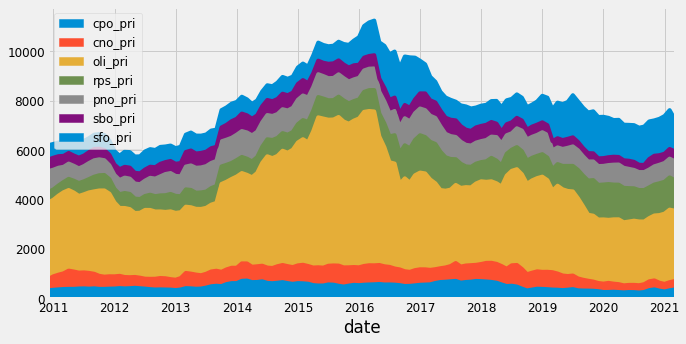

In [9]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Multi-layer Perceptron Forecasting Technique (MLP)**

###**Split Data into Train Test Segments**

In [10]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [11]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [12]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [13]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [14]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [15]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [16]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [17]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [18]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [19]:
X_train_mlp = X_train[:, :, 0]
X_test_mlp = X_test[:, :, 0]
mlp_model = tf.keras.Sequential()
mlp_model.add(tf.keras.layers.Dense(85, input_dim=X_train.shape[1], activation='relu'))
mlp_model.add(tf.keras.layers.Dense(64, activation = 'relu'))
mlp_model.add(tf.keras.layers.Dense(1))

In [20]:
mlp_model.compile(loss='mse',metrics=['mse'], optimizer='adam')
mlp_model

# model training
mlp_history = mlp_model.fit(
    X_train_mlp, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

# model evaluation
mlp_model.evaluate(X_test_mlp, y_test)

Epoch 1/100
3/3 [==============================] - 1s 110ms/step - loss: 0.1994 - mse: 0.1994 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1121 - mse: 0.1121 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0849 - val_mse: 0.0849
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0944 - val_mse: 0.0944
Epoch 8/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0196 - mse: 0.0

[0.029579782858490944, 0.029579782858490944]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


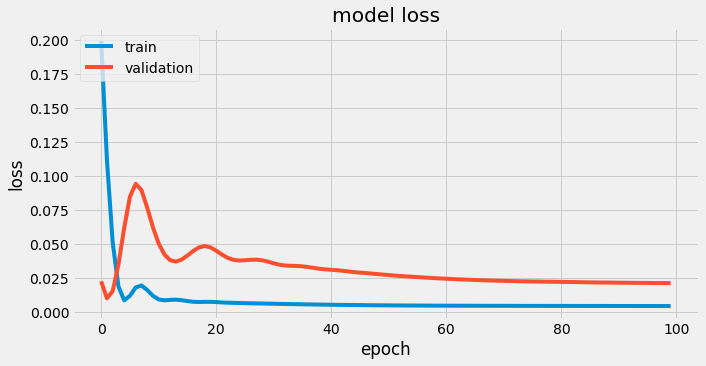

In [21]:
print(mlp_history.history.keys())
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
mse_mlp = mlp_model.evaluate(X_test_mlp, y_test)

1/1 [==============================] - 0s 29ms/step - loss: 0.0296 - mse: 0.0296


Baseline MSE = 0.0296

In [23]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                340       
                                                                 
 dense_1 (Dense)             (None, 64)                5504      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,909
Trainable params: 5,909
Non-trainable params: 0
_________________________________________________________________


###Predict the Test without Hyperparameter Tuning

In [24]:
y_pred = mlp_model.predict(X_test_mlp)
y_pred

1/1 [==============================] - 0s 290ms/step


array([[0.07942095],
       [0.13575   ],
       [0.15953703],
       [0.05364507],
       [0.10107293],
       [0.06679922],
       [0.05723274],
       [0.0508674 ],
       [0.05790282],
       [0.0718729 ],
       [0.07823094],
       [0.06669975],
       [0.0697319 ],
       [0.08306781],
       [0.07405718],
       [0.06996139],
       [0.08776607],
       [0.15313038],
       [0.16665159],
       [0.05009599],
       [0.07168632],
       [0.12025078]], dtype=float32)

In [25]:
y_pred.reshape(1,-1)

array([[0.07942095, 0.13575   , 0.15953703, 0.05364507, 0.10107293,
        0.06679922, 0.05723274, 0.0508674 , 0.05790282, 0.0718729 ,
        0.07823094, 0.06669975, 0.0697319 , 0.08306781, 0.07405718,
        0.06996139, 0.08776607, 0.15313038, 0.16665159, 0.05009599,
        0.07168632, 0.12025078]], dtype=float32)

###Invert Transformed Data

In [26]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[350.76837 373.30002 382.81482 340.45804 359.42917 345.7197  341.8931
  339.34695 342.16113 347.74918 350.29236 345.6799  346.89276 352.2271
  348.62286 346.98456 354.1064  380.25214 385.66064 339.0384  347.67453
  367.1003 ]]


###Plot History, Actual and Predicted Value

In [27]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [28]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [29]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([350.76837, 373.30002, 382.81482, 340.45804, 359.42917, 345.7197 ,
       341.8931 , 339.34695, 342.16113, 347.74918, 350.29236, 345.6799 ,
       346.89276, 352.2271 , 348.62286, 346.98456, 354.1064 , 380.25214,
       385.66064, 339.0384 , 347.67453, 367.1003 ], dtype=float32)

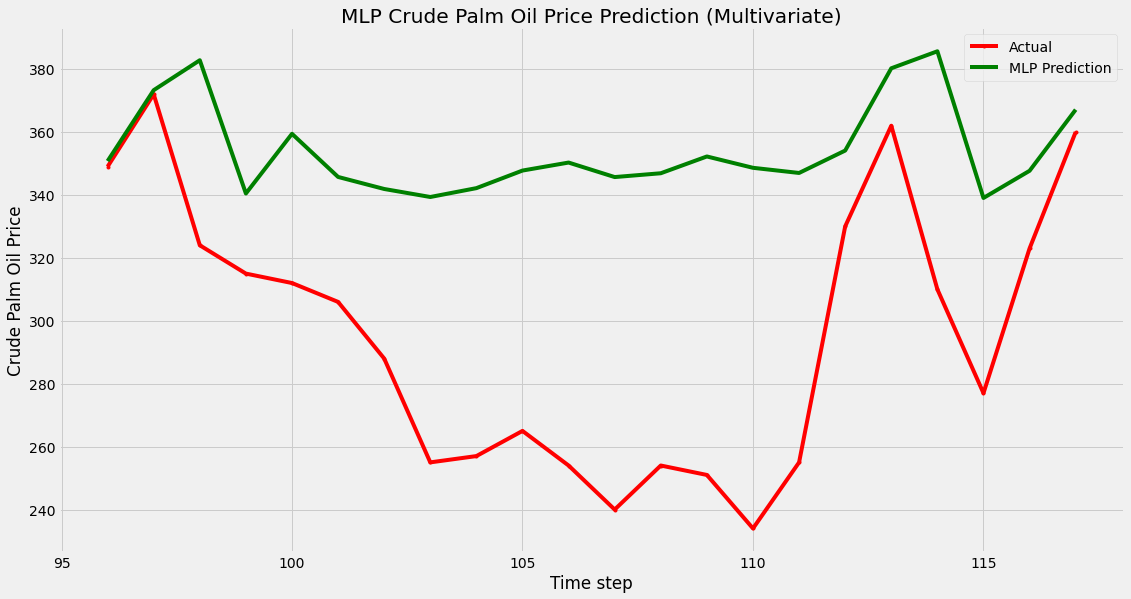

In [30]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="MLP Prediction")
plt.title("MLP Crude Palm Oil Price Prediction (Multivariate)")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
plt.savefig('graph_MLP.png')

In [31]:
y_pred_inv

array([350.76837, 373.30002, 382.81482, 340.45804, 359.42917, 345.7197 ,
       341.8931 , 339.34695, 342.16113, 347.74918, 350.29236, 345.6799 ,
       346.89276, 352.2271 , 348.62286, 346.98456, 354.1064 , 380.25214,
       385.66064, 339.0384 , 347.67453, 367.1003 ], dtype=float32)

In [32]:
MLP = y_pred_inv 
dfmlp=pd.DataFrame(MLP, columns=['MLP_Prediction']) 
print (dfmlp)

    MLP_Prediction
0       350.768372
1       373.300018
2       382.814819
3       340.458038
4       359.429169
5       345.719696
6       341.893097
7       339.346954
8       342.161133
9       347.749176
10      350.292358
11      345.679901
12      346.892761
13      352.227112
14      348.622864
15      346.984558
16      354.106415
17      380.252136
18      385.660645
19      339.038391
20      347.674530
21      367.100311


In [33]:
#Save MLP prediction to csv file
dfmlp.to_csv("MLP_Prediction.csv")

###Evaluate MLP Model Accuracy

In [34]:
MAE_MLP = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the MLP Model is:', MAE_MLP)

MDA_MLP = mda(y_test_inv, y_pred_inv)
print('MDA value of the MLP Model is:', MDA_MLP)

MAPE_MLP = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the MLP Model is:', MAPE_MLP)

RMSE_MLP = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the MLP Model is:', RMSE_MLP)

MSE_MLP = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the MLP Model is:', MSE_MLP)

MAE value of the MLP Model is: 58.87147521972656
MDA value of the MLP Model is: 0.7142857142857143
MAPE value of the MLP Model is: 22.004042287410037
RMSE value of the MLP Model is: 68.7950929766645
MSE value of the MLP Model is: 4732.764817667913


###Tuning MLP with Keras Tuner

Define A Model-Building Class

In [35]:
class MLPHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
      
        hp_units_1= hp.Int('units_1', min_value=64, max_value= 256, step=8)
        hp_units_2= hp.Int('units_2', min_value=32, max_value= 128, step=8)
        #hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=8)
        #hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2))
        #model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        #model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model
hypermodel = MLPHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [36]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

In [37]:
tuner_rs.search(X_test, y_train, epochs=16, validation_split=0.2, verbose=0)

In [60]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 364ms/step - loss: 0.0706 - mae: 0.2432 - mse: 0.0706


In [38]:
X_train_mlp = X_train[:, :, 0]
X_test_mlp = X_test[:, :, 0]
mlp_model = tf.keras.Sequential()
mlp_model.add(tf.keras.layers.Dense(85, input_dim=X_train.shape[1], activation='relu'))
mlp_model.add(tf.keras.layers.Dense(64, activation = 'relu'))
mlp_model.add(tf.keras.layers.Dense(1))

###Build HYPERBAND optimization

In [39]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [ ]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [51]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 

drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 256,
second layer is 48 

drop out is 0.35000000000000003
batch_size is 48
epoch is 100
optimizer is rmsprop
activation is ELU

momentum is 0.8300000000000001
decay is 0.00010000100000000001

#learning rate is 0.00330588674286921                                        

and the optimal learning rate for the optimizer
is 0.00330588674286921.

[]
1/1 [==============================] - 0s 325ms/step - loss: 0.0119 - mae: 0.0954 - mse: 0.0119
loss:0.011854633688926697 mae: 0.09537635743618011 mse: 0.011854633688926697


In [52]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 256, 'units_2': 48, 'dropout': 0.35000000000000003, 'optimizer': 'rmsprop', 'activation': 'ELU', 'batch_size': 48, 'epoch': 100, 'momentum': 0.8300000000000001, 'decay': 0.00010000100000000001, 'learning_rate': 0.00330588674286921}


###Apply the trained parameters to the MLP

In [41]:
#X_train_mlp = X_train[:, :, 0]
#X_test_mlp = X_test[:, :, 0]
tumlp_model = tf.keras.Sequential()
tumlp_model.add(tf.keras.layers.Dense(256,activation='ELU', input_dim=X_train.shape[1]))
tumlp_model.add(tf.keras.layers.Dense(48, activation = 'ELU'))
tumlp_model.add(tf.keras.layers.Dense(1))

In [42]:
tumlp_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.003305, momentum = 0.83), metrics= ['mae', 'mse'])
history = tumlp_model.fit(X_train_mlp, y_train, epochs=100, batch_size=48,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/100
2/2 [==============================] - 1s 219ms/step - loss: 1.2851 - mae: 0.8304 - mse: 1.2851 - val_loss: 1.9002 - val_mae: 1.2812 - val_mse: 1.9002
Epoch 2/100
2/2 [==============================] - 0s 37ms/step - loss: 0.5560 - mae: 0.6048 - mse: 0.5560 - val_loss: 1.0003 - val_mae: 0.9512 - val_mse: 1.0003
Epoch 3/100
2/2 [==============================] - 0s 59ms/step - loss: 0.4706 - mae: 0.6091 - mse: 0.4706 - val_loss: 1.0090 - val_mae: 0.9728 - val_mse: 1.0090
Epoch 4/100
2/2 [==============================] - 0s 58ms/step - loss: 0.6264 - mae: 0.7631 - mse: 0.6264 - val_loss: 0.0965 - val_mae: 0.2677 - val_mse: 0.0965
Epoch 5/100
2/2 [==============================] - 0s 40ms/step - loss: 0.3373 - mae: 0.4608 - mse: 0.3373 - val_loss: 0.3768 - val_mae: 0.5548 - val_mse: 0.3768
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 0.1506 - mae: 0.2936 - mse: 0.1506 - val_loss: 0.2676 - val_mae: 0.5000 - val_mse: 0.2676
Epoch 7/100
2/2 [==========

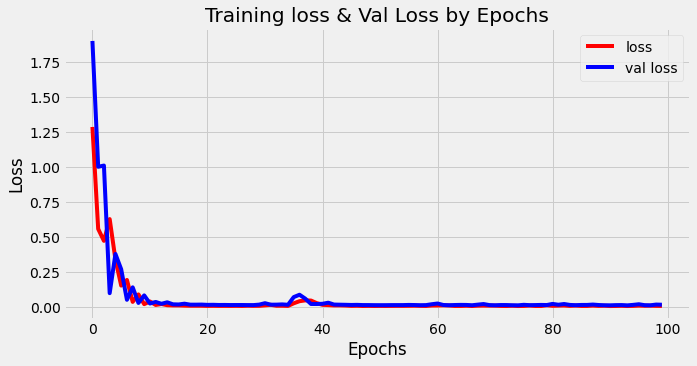

<Figure size 720x360 with 0 Axes>

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.savefig('OptTLV.png')

In [51]:
y_predTU = tumlp_model.predict(X_test_mlp)
y_predTU

1/1 [==============================] - 0s 30ms/step


array([[ 0.01911789],
       [ 0.07763793],
       [ 0.1222849 ],
       [-0.02449256],
       [-0.00233294],
       [-0.01628591],
       [-0.03256489],
       [-0.07725553],
       [-0.15292323],
       [-0.12422776],
       [-0.1128822 ],
       [-0.14863239],
       [-0.17483045],
       [-0.12830348],
       [-0.15165181],
       [-0.1910697 ],
       [-0.12133919],
       [ 0.05762442],
       [ 0.0883431 ],
       [-0.05968565],
       [-0.09717448],
       [ 0.04156507]], dtype=float32)

In [52]:
y_predTU.reshape(1,-1)

array([[ 0.01911789,  0.07763793,  0.1222849 , -0.02449256, -0.00233294,
        -0.01628591, -0.03256489, -0.07725553, -0.15292323, -0.12422776,
        -0.1128822 , -0.14863239, -0.17483045, -0.12830348, -0.15165181,
        -0.1910697 , -0.12133919,  0.05762442,  0.0883431 , -0.05968565,
        -0.09717448,  0.04156507]], dtype=float32)

In [53]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[326.64716 350.05518 367.91397 309.20297 318.06683 312.48563 305.97406
  288.09778 257.83072 269.3089  273.84714 259.54706 249.06783 267.67862
  258.3393  242.57211 270.46432 342.04977 354.33725 295.12573 280.13022
  335.62604]]


In [54]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [55]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [56]:
TU_MLP_Pred = y_pred_inv.flatten()   
TU_MLP_Pred

array([326.64716, 350.05518, 367.91397, 309.20297, 318.06683, 312.48563,
       305.97406, 288.09778, 257.83072, 269.3089 , 273.84714, 259.54706,
       249.06783, 267.67862, 258.3393 , 242.57211, 270.46432, 342.04977,
       354.33725, 295.12573, 280.13022, 335.62604], dtype=float32)

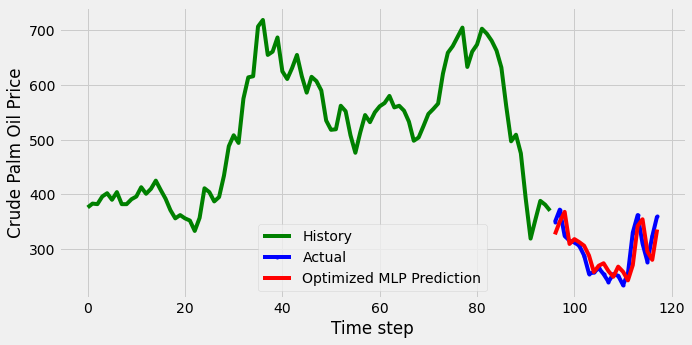

<Figure size 720x360 with 0 Axes>

In [57]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_MLP_Pred, color='red', label="Optimized MLP Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();
plt.savefig('MLPOpt.png')

###Evaluate MLP Model Accuracy

In [58]:
TUMAE_mlp = mean_absolute_error(y_test_inv, TU_MLP_Pred)
print('MAE value of the MLP Model is:', TUMAE_mlp)

TUMDA_mlp = mda(y_test_inv, TU_MLP_Pred)
print('MDA value of the tuned MLP Model is:', TUMDA_mlp)

TUMAPE_mlp = mean_absolute_percentage_error(y_test_inv, TU_MLP_Pred)
print('MAPE value of the tuned MLP Model is:', TUMAPE_mlp)

TURMSE_mlp = mean_squared_error(y_test_inv,TU_MLP_Pred, squared=False)
print('RMSE value of the tuned MLP Model is:', TURMSE_mlp)

TUMSE_mlp = mean_squared_error(y_test_inv,TU_MLP_Pred)
print('MSE value of the tuned MLP Model is:', TUMSE_mlp)

MAE value of the MLP Model is: 21.351699135520242
MDA value of the tuned MLP Model is: 0.5714285714285714
MAPE value of the tuned MLP Model is: 7.145136399049895
RMSE value of the tuned MLP Model is: 26.07160288447993
MSE value of the tuned MLP Model is: 679.7284769660222


###Comparing tuned MLP Actual VS Predicted (Zoomed-IN)

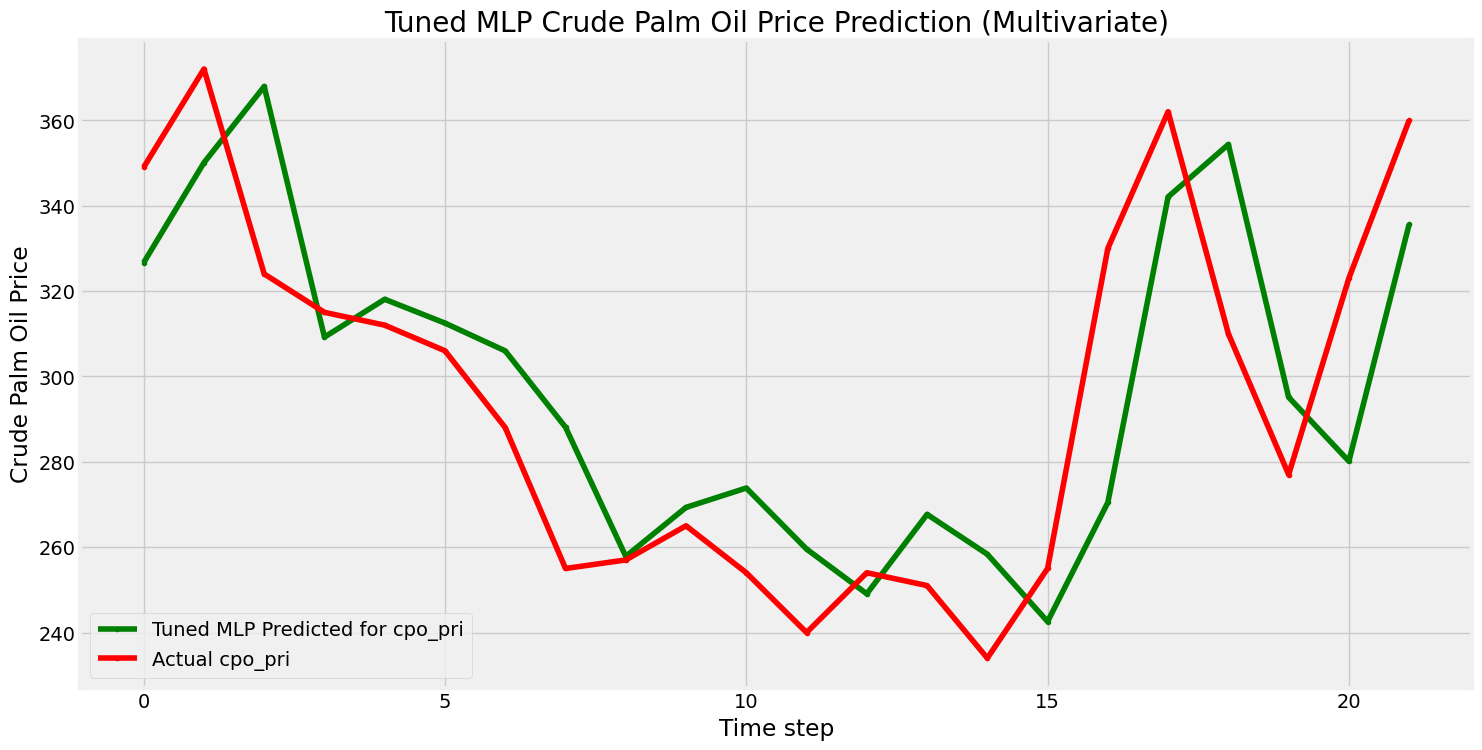

<Figure size 720x360 with 0 Axes>

In [59]:
#Plot the graph between actual vs predicted values
#plt.figure(figsize=(15,7))  #(10,6))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(TU_MLP_Pred, color= 'green',marker='.',label = 'Tuned MLP Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned MLP Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TUmlp.png')

###Results

* Baseline MSE = 0.0296
* Random search MSE = 0.0706
* Hyperband MSE = 0.01185
* Baseline (CNN) RSME = 68.79
* Tuned CNN RSME = 26.07

